# Final Project
Week 5: Capstone Project 

## Outlines

1. Preparation
    - Import libraries
    - Declare params
2. Get the full list of venue categories using FourSquare API
3. Load the dataset of the target city's local neighborhoods (neighborhood name vs. geo coordinates)
4. Retrieve venues in each neighborhood with FourSquare API
5. Translate all venues' categories information into neighborhoods' feature vectors
6. Transform features (scaling)
7. Clustering
    - DBSCAN
    - KMeans
8. Visualize the clusters on a map
9. Retrieve venues of the current hometown (Vancouver) with FourSquare API
10. Find the most similar cluster of neighborhoods in the target city (Toronto)
11. Visualize the results to see the similarity (or disimilarity).

---


# Preparation.

Importing libraries

In [54]:
# !pip3 install folium
# !pip3 install sklearn
import collections
import numpy as np
import pandas as pd
import folium
import requests
from pandas.io.json import json_normalize
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

Params for FourSquare API requests

In [2]:
CLIENT_ID = 'LVQ521WZ0ZVT1LNDBDI4FEC4TH5GTPFUJ3IQT21HTNJN4QUO'
CLIENT_SECRET = 'PUZJSH44LO0PW3S5BX4ISNSN1GBPBX0T55NBO4ELRQFTRAUA'
VERSION = '20180605'

# Get FourSquare's Venue Categories.

According to FourSquare's [Developers Docs](https://developer.foursquare.com/docs/api/venues/categories), I get the hierarchical list of categories using the request:
```
GET https://api.foursquare.com/v2/venues/categories
```

Response is a json describing the 10 main categories and their 5-145 subcategories. Here, I will create a list of 456 components, respectively to the 456 subcategories, which will be used in later stage for creating feature vector for each neighborhood.

| Category                    | Numer of subcategories |
|-----------------------------|------------------------|
| Arts & Entertainment        | 36                     |
| College & University        | 23                     |
| Event                       | 12                     |
| Food                        | 91                     |
| Nightlife Spot              | 7                      |
| Outdoors & Recreation       | 62                     |
| Professional & Other Places | 41                     |
| Residence                   | 5                      |
| Shop & Service              | 145                    |
| Travel & Transport          | 34                     |
| **Total**                   | **456**                |



In [3]:
url = 'https://api.foursquare.com/v2/venues/categories?&client_id={}&client_secret={}&v={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)            
# make the GET request
results = requests.get(url).json()['response']['categories']

categories = []
for cat in results:
    subcats = cat['categories']
    for subcat in subcats:
        categories.append(subcat['name'])

print(categories[:10])
print('There are', len(categories), 'categories retrieved.')

['Amphitheater', 'Aquarium', 'Arcade', 'Art Gallery', 'Bowling Alley', 'Casino', 'Circus', 'Comedy Club', 'Concert Hall', 'Country Dance Club']
There are 456 categories retrieved.


# Load Toronto's neighborhood geo-coordinates.

Thanks to preprocessing steps from previous weeks, we have a dataset of 103 neighborhoods in Toronto and their coordinates.

In [7]:
neigh_df = pd.read_pickle('3.2.pkl')[['Neighborhood', 'Latitude', 'Longitude']]
print('There are' , neigh_df.shape[0], 'neighborhoods loaded.')
neigh_df.head()

There are 103 neighborhoods loaded.


,Neighborhood,Latitude,Longitude
0,"Rouge, Malvern",43.806686,-79.194353
1,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,Woburn,43.770992,-79.216917
4,Cedarbrae,43.773136,-79.239476


# Explore neighborhoods using FourSquare API.

For each neighborhood, I use the [Get Venue Recommendations API](https://developer.foursquare.com/docs/api/venues/explore) to get the information of interest, i.e., latitude and logitude.

```
GET https://api.foursquare.com/v2/venues/explore
```

Outcome of this step is a dataframe with each line is a venue, desribed by 3 attributes: the neighborhood that it is in, venue name, and its category.

In [8]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000, limit=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            v['venue']['name'], 
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Venue', 
                  'Venue Category']
    
    return(nearby_venues)

toronto_venues_df = getNearbyVenues(neigh_df['Neighborhood'],
                                    neigh_df['Latitude'],
                                    neigh_df['Longitude'])
print('There are', toronto_venues_df.shape[0], 
      'venues over', len(toronto_venues_df['Neighborhood'].unique()), 'neighborhoods')
toronto_venues_df.head()

There are 4836 venues over 102 neighborhoods


,Neighborhood,Venue,Venue Category
0,"Rouge, Malvern",Images Salon & Spa,Spa
1,"Rouge, Malvern",Caribbean Wave,Caribbean Restaurant
2,"Rouge, Malvern",Harvey's,Fast Food Restaurant
3,"Rouge, Malvern",Wendy's,Fast Food Restaurant
4,"Rouge, Malvern",Wendy's,Fast Food Restaurant


# Feature Vectors.

We will create a histogram of venue categories for each neighborhood as a feature vector using one hot encoding.

In [9]:
full_cat = pd.DataFrame({'Venue Category' : categories})
temp_df = pd.concat([toronto_venues_df[toronto_venues_df['Venue Category'].isin(categories)], full_cat], ignore_index = True)
toronto_venues_onehot = pd.get_dummies(temp_df[['Venue Category']], prefix="", prefix_sep="")
toronto_venues_onehot = toronto_venues_onehot[:-len(categories)] # remove the dummy rows
# add the neighborhood column back
toronto_venues_onehot.insert(0, 'Neighborhood', toronto_venues_df['Neighborhood'])

Now group venues by neighborhood to get the feature vector of each neighborhood.

In [10]:
toronto_neigh_onehot = toronto_venues_onehot.groupby('Neighborhood').sum()
toronto_neigh_onehot.to_pickle('toronto_train.pkl')
toronto_neigh_onehot.head()

,ATM,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,...,Watch Shop,Water Park,Waterfall,Waterfront,Wedding Hall,Well,Windmill,Winery,Wings Joint,Zoo
Neighborhood,,,,,,,,,,,,,,,,,,,,,
"Adelaide, King, Richmond",0,0,0,0,0,5,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Agincourt,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"Agincourt North, L'Amoreaux East, Milliken, Steeles East",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"Bathurst Manor, Downsview North, Wilson Heights",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Bayview Village,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Transform Features.

As different categories might have totally different number of venues, e.g., 100 restaurants but there is only 1 beach. We need to normalize the input before inputting to clustering model.

In [11]:
scaler = StandardScaler()
X = scaler.fit_transform(toronto_neigh_onehot.astype(float))

# Clustering.

## DBSCAN.

Use DBSCAN to cluster neighborhoods in Toronto

In [26]:
db = DBSCAN(eps=10, min_samples=2)
db.fit(X)
labels = db.labels_
clusterNo = len(set(labels)) - (1 if -1 in labels else 0)
print('There are', clusterNo, 'clusters detected.')
print(collections.Counter(labels))
clustered_df = toronto_neigh_onehot.copy()
clustered_df.insert(0, "Cluster", labels)
clustered_df.head()

There are 1 clusters detected.
Counter({-1: 47, 0: 25})


,Cluster,ATM,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,...,Watch Shop,Water Park,Waterfall,Waterfront,Wedding Hall,Well,Windmill,Winery,Wings Joint,Zoo
Neighborhood,,,,,,,,,,,,,,,,,,,,,
"Adelaide, King, Richmond",-1,0,0,0,0,0,5,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Agincourt,-1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"Agincourt North, L'Amoreaux East, Milliken, Steeles East",-1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"Bathurst Manor, Downsview North, Wilson Heights",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Bayview Village,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


DBScan seems not to be efficient in clustering data in large dimensity like this.

## KMeans.

Or we can also use KMeans to cluster neighborhoods in Toronto

In [27]:
kclusters = 10
kmeans = KMeans(n_clusters=kclusters, random_state=5).fit(X)
labels = kmeans.labels_
print('There are', len(set(labels)), 'clusters detected.')
print(collections.Counter(labels))
clustered_df = toronto_neigh_onehot.copy()
clustered_df.insert(0, "Cluster", labels)
clustered_df.head()

There are 10 clusters detected.
Counter({1: 44, 6: 16, 4: 3, 0: 3, 7: 1, 5: 1, 8: 1, 3: 1, 9: 1, 2: 1})


,Cluster,ATM,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,...,Watch Shop,Water Park,Waterfall,Waterfront,Wedding Hall,Well,Windmill,Winery,Wings Joint,Zoo
Neighborhood,,,,,,,,,,,,,,,,,,,,,
"Adelaide, King, Richmond",4,0,0,0,0,0,5,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Agincourt,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"Agincourt North, L'Amoreaux East, Milliken, Steeles East",1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"Bathurst Manor, Downsview North, Wilson Heights",1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Bayview Village,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Visualization.

In order to visulaize the nigheborhoods in different custers, we first need to aggragate the spatial geo-coordinates back to the dataframe.

In [104]:
agg_df = neigh_df.set_index('Neighborhood').join(clustered_df, how='right')
agg_df.head(5)

,Latitude,Longitude,Cluster,ATM,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Amphitheater,...,Watch Shop,Water Park,Waterfall,Waterfront,Wedding Hall,Well,Windmill,Winery,Wings Joint,Zoo
Neighborhood,,,,,,,,,,,,,,,,,,,,,
"Adelaide, King, Richmond",43.650571,-79.384568,4,0,0,0,0,0,5,0,...,0,0,0,0,0,0,0,0,0,0
Agincourt,43.794200,-79.262029,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"Agincourt North, L'Amoreaux East, Milliken, Steeles East",43.815252,-79.284577,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"Bathurst Manor, Downsview North, Wilson Heights",43.754328,-79.442259,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Bayview Village,43.786947,-79.385975,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Then we can use Folium library to illustrate the neighborhoods with different colors for different clusters.

In [29]:
latitude = 43.7032
longitude = -79.3832

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(agg_df['Latitude'], agg_df['Longitude'], agg_df.index.values, agg_df['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# Explore the "current" neighborhoods using FourSquare API.

Again, we can take advantage of FourSquare API to retrieve information about the current hometown, and use these information to create a feature vector for the hometown.

In [30]:
hometown_venues = getNearbyVenues(['My Hometown'],[49.2827],[-123.1207])
full_cat = pd.DataFrame({'Venue Category' : categories})
tmp_df = pd.concat([hometown_venues[hometown_venues['Venue Category'].isin(categories)], full_cat], ignore_index = True)
hometown_venues_onehot = pd.get_dummies(tmp_df[['Venue Category']], prefix="", prefix_sep="")
hometown_venues_onehot = hometown_venues_onehot[:-len(categories)]

hometown_venues_onehot.insert(0, 'Neighborhood', hometown_venues['Neighborhood'])
hometown_neigh_onehot = hometown_venues_onehot.groupby('Neighborhood').sum()
hometown_neigh_onehot.to_pickle('vancouver_test.pkl')
hometown_neigh_onehot

,ATM,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,...,Watch Shop,Water Park,Waterfall,Waterfront,Wedding Hall,Well,Windmill,Winery,Wings Joint,Zoo
Neighborhood,,,,,,,,,,,,,,,,,,,,,
My Hometown,0,0,0,0,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Find the likelihood cluster of neighborhood.

Now it's time to use the pre-computed cluster model in previous steps to find the most similar neighborhoods in Toronto.  

In [31]:
X_test = scaler.transform(hometown_neigh_onehot.astype(float))
yhat_test = kmeans.predict(X_test)
print(yhat_test)

[6]


According to KMeans, the most similar neighborhoods are those in cluster #6, which includes 16 neighborhoods in Toronto.

# Validating the similarity.

So the last step is that we need to explore the data to verify if these neighborhoods are actually similar (or not).

## Visualizing.

One of the most obvious ways is to visualize the target neighborhoods again to see where they are in the big city.

In [32]:
# Filter data
cluster6 = agg_df[agg_df['Cluster'] == 6]

In [35]:
latitude = 43.7032
longitude = -79.3832

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(cluster6['Latitude'], cluster6['Longitude'], cluster6.index.values, cluster6['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

**Tadah, most of them are right in the Toronto downtown! (Clearly, because my "current hometown" is actually Vancouver downtown. They are all expensive, I am sure. Lol)**

## Histogram.

Another way to see the result is to visualize their histogram. I think it's better to "shrink" the long long feature vector to a shortened version of 10 main categories instead of 456 subcategories.  

First, we identify the indices of subcategories in the feature vector.

In [46]:
cat_size = [36, 23, 12, 91, 7, 62, 41, 5, 145, 34]
cat_start = [sum(cat_size[:index]) for index in range(len(cat_size))]
cat_start.append(len(categories))

We then take the mean of cluster #6 the group subcategories into 10 main categories.

In [50]:
cluster_6_mean = cluster6.groupby('Cluster').mean()
cluster_6_hist = pd.DataFrame()
for i in range(len(cat_size)):
    cat_name = results[i]['name']
    cat_count = cluster_6_mean.iloc[0,2+cat_start[i]:2 + cat_start[i+1]].sum()
    cluster_6_hist[cat_name] = [cat_count]

Finally, plot the histogram.

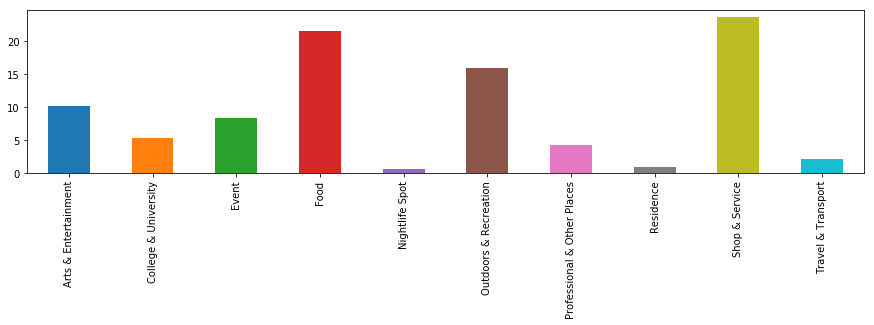

In [55]:
cluster_6_hist.iloc[0,:].plot(kind='bar', figsize=(15,3), legend=None)
plt.show()

Similarly, we will do for the current hometown, which particularly is downtown Vancouver in this example.

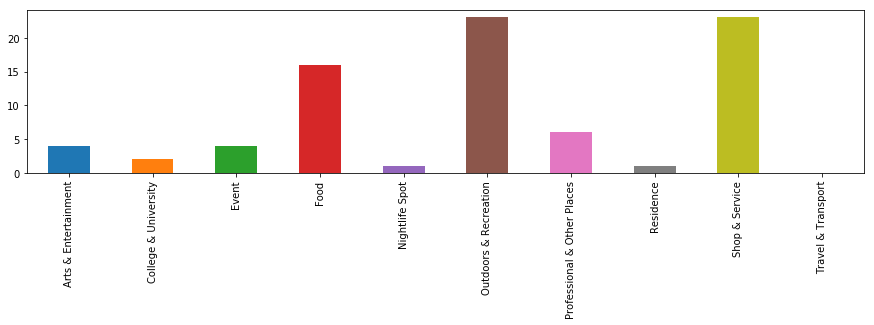

In [57]:
hometown_neigh_onehot
hometown_hist = pd.DataFrame()
for i in range(len(cat_size)):
    cat_name = results[i]['name']
    cat_count = hometown_neigh_onehot.iloc[0,cat_start[i]:cat_start[i+1]].sum()
    hometown_hist[cat_name] = [cat_count]
    
hometown_hist.iloc[0,:].plot(kind='bar', figsize=(15,3), legend=None)
plt.show()

**Well, there is a common pattern in their histogram of venue categories, isn't it?**

This is also the end of this project, I can finally identifies the most potential neighborhood in Toronto for Andy:

In [59]:
agg_df[agg_df['Cluster'] == 6].index.values

array(['Chinatown, Grange Park, Kensington Market',
       'Commerce Court, Victoria Hotel', 'Davisville', 'Davisville North',
       'Deer Park, Forest Hill SE, Rathnelly, South Hill, Summerhill West',
       'Design Exchange, Toronto Dominion Centre', 'East Toronto',
       'Harbord, University of Toronto', 'Leaside',
       'Moore Park, Summerhill East', 'Ryerson, Garden District',
       'St. James Town', 'Stn A PO Boxes 25 The Esplanade',
       'Studio District', 'The Beaches West, India Bazaar',
       'The Danforth West, Riverdale'], dtype=object)

Thank you for reviewing my project!  

**Notebook created by [Thinh Nguyen-Vo](http://thinh.ca)**

---

# Appendix

Some extra analysis

In [61]:
subcat_tocat = dict()
for cat in results:
    catname = cat['name']
    for subcat in cat['categories']:
        subcat_name = subcat['name']
        subcat_tocat[subcat_name] = catname

In [71]:
def toCat(subcatlist):
    cat = []
    for subcat in subcatlist:
        cat.append(subcat_tocat[subcat] if subcat in subcat_tocat else np.nan)
    return cat

In [73]:
toronto_venues_df['Category'] = toCat(toronto_venues_df['Venue Category'])
toronto_venues_df.head()

,Neighborhood,Venue,Venue Category,Category
0,"Rouge, Malvern",Images Salon & Spa,Spa,Shop & Service
1,"Rouge, Malvern",Caribbean Wave,Caribbean Restaurant,Food
2,"Rouge, Malvern",Harvey's,Fast Food Restaurant,Food
3,"Rouge, Malvern",Wendy's,Fast Food Restaurant,Food
4,"Rouge, Malvern",Wendy's,Fast Food Restaurant,Food


In [100]:
count_cat_neigh = toronto_venues_df.groupby(['Neighborhood', 'Category']).count()
count_cat_neigh = count_cat_neigh[['Venue']]
count_cat_neigh.reset_index(inplace = True)
count_cat_neigh.head(10)

,Neighborhood,Category,Venue
0,"Adelaide, King, Richmond",Arts & Entertainment,7
1,"Adelaide, King, Richmond",College & University,1
2,"Adelaide, King, Richmond",Food,37
3,"Adelaide, King, Richmond",Nightlife Spot,4
4,"Adelaide, King, Richmond",Outdoors & Recreation,2
5,"Adelaide, King, Richmond",Shop & Service,13
6,"Adelaide, King, Richmond",Travel & Transport,6
7,Agincourt,Arts & Entertainment,1
8,Agincourt,Food,16
9,Agincourt,Nightlife Spot,1


In [101]:
count_cat_neigh.groupby('Category').describe()

Venue                                        \
                             count       mean        std  min  25%   50%   
Category                                                                   
Arts & Entertainment          45.0   2.822222   2.289193  1.0  1.0   2.0   
College & University           7.0   1.285714   0.487950  1.0  1.0   1.0   
Food                         101.0  21.891089  18.167499  1.0  6.0  16.0   
Nightlife Spot                43.0   3.023256   2.324695  1.0  1.0   2.0   
Outdoors & Recreation         85.0   3.176471   2.155704  1.0  2.0   3.0   
Professional & Other Places   14.0   1.071429   0.267261  1.0  1.0   1.0   
Residence                      1.0   2.000000        NaN  2.0  2.0   2.0   
Shop & Service                97.0   6.855670   4.472112  1.0  3.0   6.0   
Travel & Transport            57.0   2.561404   2.507258  1.0  1.0   2.0   

                                         
                              75%   max  
Category                                 
Arts & Entertainment          5.0   9.0  
College & University          1.5   2.0  
Food                         38.0  57.0  
Nightlife Spot                4.0   9.0  
Outdoors & Recreation         4.0  10.0  
Professional & Other Places   1.0   2.0  
Residence                     2.0   2.0  
Shop & Service                9.0  21.0  
Travel & Transport            3.0  11.0

In [86]:
s01 = count_cat_neigh[count_cat_neigh['Category'] == 'Arts & Entertainment']['Venue']
s02 = count_cat_neigh[count_cat_neigh['Category'] == 'College & University']['Venue']
s03 = count_cat_neigh[count_cat_neigh['Category'] == 'Food']['Venue']
s04 = count_cat_neigh[count_cat_neigh['Category'] == 'Nightlife Spot']['Venue']
s05 = count_cat_neigh[count_cat_neigh['Category'] == 'Outdoors & Recreation']['Venue']
s06 = count_cat_neigh[count_cat_neigh['Category'] == 'Professional & Other Places']['Venue']
s07 = count_cat_neigh[count_cat_neigh['Category'] == 'Residence']['Venue']
s08 = count_cat_neigh[count_cat_neigh['Category'] == 'Shop & Service']['Venue']
s09 = count_cat_neigh[count_cat_neigh['Category'] == 'Travel & Transport']['Venue']

In [84]:
import scipy.stats as stats

In [102]:
res = stats.f_oneway(s01, s02, s03, s04, s05, s06, s07, s08, s09)
res

F_onewayResult(statistic=40.546461409860527, pvalue=2.2814363864612238e-48)

In [89]:
import seaborn as sns

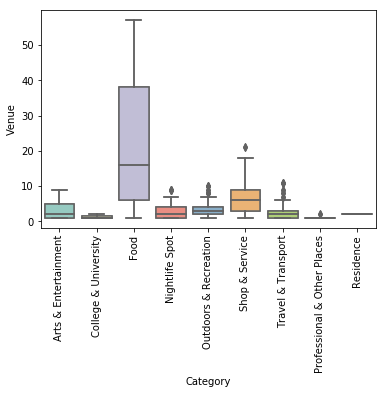

In [93]:
ax = sns.boxplot(x="Category", y="Venue", data=count_cat_neigh, palette="Set3")
for item in ax.get_xticklabels():
    item.set_rotation(90)
plt.show()